# Estimation of simulated VAR by ML using only  numpy

## Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

np.random.seed(1)

## Simulation of stationary time-series

In [2]:
# Time-series dimension of simulation

nsample = 1000
nvar = 4

In [3]:
# Create null data frames for storing data

df = np.empty((nsample, nvar))
rho = np.empty((nvar))

In [4]:
# Simulation of processes

# Start values

for i in np.arange(0, df.shape[1]):
    df[0,i] = np.random.random()
    
# Rho parameters, smaller than one in absolute value
for i in np.arange(0, df.shape[1]):
    rho[i] = np.random.uniform(-0.99, 0.99)

# Create the AR(1) processes
for i in np.arange(1,df.shape[0]):
    for j in np.arange(0, df.shape[1]):
        df[i,j] = rho[j]*df[i-1, j] + np.random.normal()

# print(df)

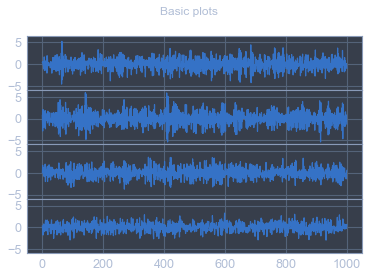

In [5]:
# Plots

f, axarr = plt.subplots(df.shape[1], sharex=True, sharey=True)
f.suptitle('Basic plots')

for i in np.arange(0, df.shape[1]):
    axarr[i].plot(df[:,i])

# Bring subplots close to each other.
f.subplots_adjust(hspace=0)

# Hide x labels and tick labels for all but bottom plot.
for ax in axarr:
    ax.label_outer()

## VAR

In [6]:
class VAR:
    """ 
    **** VECTOR AUTOREGRESSION (VAR) MODELS ****
    ----------
    Parameters
    data : np.array
        Field to specify the time series data that will be used.
    lags : int
        Field to specify how many lag terms the model will have. 
    integ : int (default : 0)
        Specifies how many time to difference the dependent variables.
    target : str (pd.DataFrame) or int (np.array) (default : None)
        By default, all columns will be selected as the dependent variables.
    """

    def __init__(self,data,lags,target=None,integ=0):
        
        # Latent Variables
        self.lags = lags
        self.integ = integ
        self.target = target
        self.model_name = "VAR(" + str(self.lags) + ")"
        
        # Format the dependant variables
        self.data = data
        self.T = data.shape[0]
        self.ylen = data.shape[1]
        
        # Format the independent variables
        
        ## TO DO
        
        # Difference data
        X = np.transpose(self.data)
        for order in np.arange(self.integ):
            X = np.asarray([np.diff(i) for i in X])
            self.data_name = np.asarray(["Differenced " + str(i) for i in self.data_name])
        self.data = X.T
        
        """
        Y : np.array
            Contains the length-adjusted time series (accounting for lags)
        """     

        self.Y = (self.data[self.lags:,]).T
        
    def _design(self):
        """ Creates a design matrix
        Z : np.array
        """ 
        
        Z = np.ones(((self.ylen*self.lags+1), (self.T-self.lags)))

        row_count=1
        for lag in np.arange(1, self.lags+1):
            for reg in np.arange(self.ylen):
                Z[row_count, :] = self.data[:,reg][(self.lags-lag):-lag]
                row_count += 1
                
        return(Z)

    def OLS(self):
        """ Creates OLS coefficient matrix
        ----------
        Parameters:
        NULL
        ----------
        Returns
        The coefficient matrix B
        """         
        
        Z = self._design()
        return np.dot(np.dot(self.Y,np.transpose(Z)),np.linalg.inv(np.dot(Z,np.transpose(Z))))
    
    def _neg_loglike(self, par):
        """ Calculate the MLE value, given the mean vector and variance matrix        
        """
        
        Z = self._design()[1:]
        
        coef = np.reshape(par[0:self.ylen**2], (self.ylen, self.ylen))
        coef_mean = par[self.ylen**2:self.ylen**2+self.ylen]
        coef_var = np.diag(par[self.ylen**2+self.ylen:])    
    
        Y_0 = (self.Y.T - coef_mean).T
        Z_0 = (Z.T - coef_mean).T 
        
        logLik = -self.Y.shape[1]*self.ylen*np.log(2*np.pi)*.5 - .5*self.Y.shape[1]*np.log(np.abs(np.linalg.det(coef_var)))- .5*np.trace(np.dot(np.dot((Y_0 - np.dot(coef,Z_0)).T,np.linalg.inv(coef_var)),Y_0 - np.dot(coef,Z_0)))
        
        return -logLik

    def MLE(self):
        """ Creates MLE coefficient matrix
        ----------
        Parameters:
        NULL
        ----------
        Returns
        The coefficient matrix MLE
        ----------
        It is based on the assumption of normality of errors
        """     
        
        cons = []
        
        for i in np.arange(self.ylen):
            cons.append(dict({'type':'ineq', 'fun': eval("lambda x: x[-" + str(i) + "]")}))
        
        # Make a list of initial parameter guesses 
        
        initParams = np.repeat(1, (self.ylen)**2 + self.ylen + self.ylen)

        # Run the minimizer
        results = minimize(self._neg_loglike, initParams, constraints = cons, method='COBYLA')

        # Print the results
        return(results.x)

In [7]:
# Estimate VAR(1) by OLS

# In general

OLS_results = VAR(data = df, lags = 1, target = None, integ = 0).OLS()
OLS_results

# For more clarity

par_names_OLS = ['A Constant','A AR(1)','B to A AR(1)','C to A AR(1)','D to A AR(1)',
                 'B Constant','B AR(1)','A to B AR(1)','C to B AR(1)','D to B AR(1)',
                 'C Constant','C AR(1)','A to C AR(1)','B to C AR(1)', 'D to C AR(1)',
                 'D Constant','D AR(1)','A to D AR(1)','B to D AR(1)', 'C to D AR(1)'] 

results_OLS =  dict(zip(par_names_OLS, OLS_results.flatten()))
results_OLS

{'A Constant': 0.01010538635621291,
 'A AR(1)': -0.7055232088859222,
 'B to A AR(1)': 0.008819560796300707,
 'C to A AR(1)': 0.02070126311884091,
 'D to A AR(1)': 0.02709696876572987,
 'B Constant': -0.04413308761845076,
 'B AR(1)': 0.02611211280166218,
 'A to B AR(1)': -0.8138454542977532,
 'C to B AR(1)': -0.006427980734328676,
 'D to B AR(1)': -0.04704891837392927,
 'C Constant': 0.01926967806551043,
 'C AR(1)': -0.0006427545452451516,
 'A to C AR(1)': 0.009698421242716023,
 'B to C AR(1)': -0.635662678872401,
 'D to C AR(1)': -0.0387518766048352,
 'D Constant': 0.062350840682147635,
 'D AR(1)': -0.059201152076564664,
 'A to D AR(1)': -0.009013081435577584,
 'B to D AR(1)': -0.01163950876654401,
 'C to D AR(1)': -0.22523373893589382}

In [8]:
# Estimate VAR(1) by MLE

MLE_results = VAR(data = df, lags = 1, target = None, integ = 0).MLE()
MLE_results

par_names_MLE = ['A AR(1)','B to A AR(1)','C to A AR(1)','D to A AR(1)',
                 'B AR(1)','A to B AR(1)','C to B AR(1)','D to B AR(1)',
                 'C AR(1)','A to C AR(1)','B to C AR(1)', 'D to C AR(1)',
                 'D AR(1)','A to D AR(1)','B to D AR(1)', 'C to D AR(1)',
                 'A Constant','B Constant', 'C Constant', 'D Constant',
                 'Var(A)','Var(B)','Var(C)','Var(D)'] 

results_MLE = dict(zip(par_names_MLE, MLE_results.flatten()))
results_MLE

{'A AR(1)': -2.306038150315576e-19,
 'B to A AR(1)': 0.07285971195939525,
 'C to A AR(1)': 0.01939584274170388,
 'D to A AR(1)': -0.06803269931117267,
 'B AR(1)': 0.02590013418894838,
 'A to B AR(1)': -0.8135157704148301,
 'C to B AR(1)': -0.006609828276350366,
 'D to B AR(1)': -0.04710269742026835,
 'C AR(1)': -0.0009164158351410184,
 'A to C AR(1)': 0.009756276191233293,
 'B to C AR(1)': -0.6355429623634855,
 'D to C AR(1)': -0.038759511124099255,
 'D AR(1)': -0.058965473781018074,
 'A to D AR(1)': -0.008841260720395828,
 'B to D AR(1)': -0.01123750636862695,
 'C to D AR(1)': -0.2254193777719886,
 'A Constant': 0.006134127008689373,
 'B Constant': -0.025346900186250212,
 'C Constant': 0.010416346168505154,
 'D Constant': 0.05151656375672152,
 'Var(A)': 2.0399138008925686,
 'Var(B)': 0.9899443520546938,
 'Var(C)': 0.9868341245697729,
 'Var(D)': 0.9599688430626565}